In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("..")
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.data import utils
from nsrr import nsrr_utils

viz.notebook_full_width()
%matplotlib inline

In [13]:
dataset_name = 'shhs1'
dataset_path = os.path.abspath(os.path.join(utils.PATH_DATA, dataset_name, 'register_and_state'))
subject_files = os.listdir(dataset_path)
subject_files = [f for f in subject_files if '.npz' in f]
print(subject_files)

['shhs1-200003.npz', 'shhs1-200009.npz', 'shhs1-200002.npz', 'shhs1-200001.npz', 'shhs1-200007.npz', 'shhs1-200004.npz', 'shhs1-200008.npz', 'shhs1-200010.npz', 'shhs1-200006.npz', 'shhs1-200005.npz']


dataset : shhs1
subject_id : shhs1-200004
channel : EEG(sec)
sampling_rate : 200
epoch_duration : 30.0
bandpass_filter : scipy.signal.butter, 0.1-35Hz, order 3
resampling_function : scipy.signal.resample_poly
original_sampling_rate : 125.0

Fraction of hypnogram in N2: 0.6941176470588235

Fraction of hypnogram in W: 0.050980392156862744


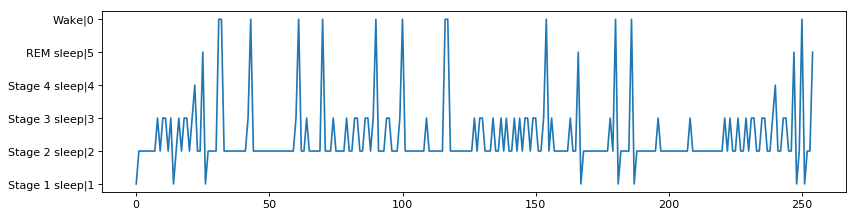


Fraction of NEW hypnogram in N2: 0.6941176470588235
New size as a fraction of original size: 1.0


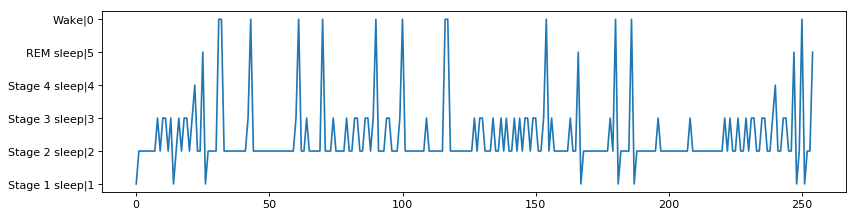

In [14]:
single_file = subject_files[5]

data_dict = np.load(os.path.join(dataset_path, single_file))

for key in ['dataset', 'subject_id', 'channel', 'sampling_rate', 'epoch_duration', 'bandpass_filter', 'resampling_function', 'original_sampling_rate']:
    print(key,":",data_dict[key])
    
signal = data_dict['signal']
hypnogram = data_dict['hypnogram']
fs = data_dict['sampling_rate']

n2_id = 'Stage 2 sleep|2'
w_id = 'Wake|0'
n2_fraction = np.mean(hypnogram == n2_id)
w_fraction = np.mean(hypnogram == w_id)
print("\nFraction of hypnogram in N2:", n2_fraction)
print("\nFraction of hypnogram in W:", w_fraction)

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=80)
ax.plot(hypnogram)
plt.show()

# ignorar inicios y fines en etapa Wake|0 o ?
# mejor aun:only N2 como en cap, usando la segmentacion original de 30s
epoch_samples = int(30 * fs)
new_signal, new_hypnogram = nsrr_utils.short_signal_to_n2(signal, hypnogram, epoch_samples, n2_id)

n2_fraction = np.mean(new_hypnogram == n2_id)
print("\nFraction of NEW hypnogram in N2:", n2_fraction)
print("New size as a fraction of original size:", new_hypnogram.size / hypnogram.size)

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=80)
ax.plot(new_hypnogram)
plt.show()


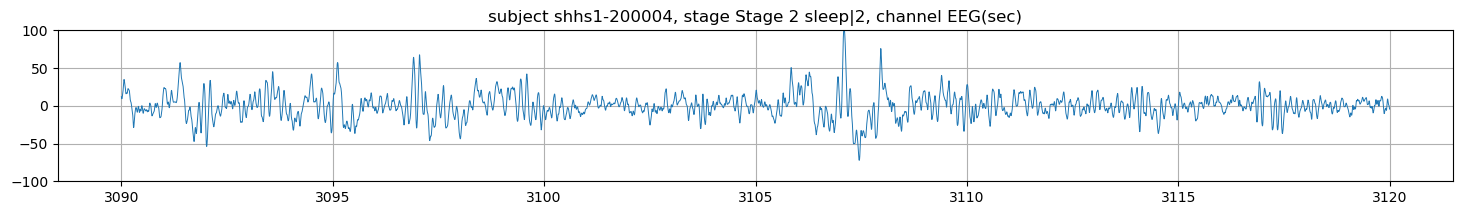

In [29]:
page_to_draw = 103

epoch_samples = int(data_dict['epoch_duration'] * fs)
start_sample = page_to_draw * epoch_samples
end_sample = start_sample + epoch_samples

segment_signal = signal[start_sample:end_sample]
stage = hypnogram[page_to_draw]
time_axis = np.arange(start_sample, end_sample) / fs

fig, ax = plt.subplots(1, 1, figsize=(18, 2), dpi=100)
ax.plot(time_axis, segment_signal, linewidth=0.7)
title_str = 'subject %s, stage %s, channel %s' % (data_dict['subject_id'], stage, data_dict['channel'])
ax.set_title(title_str)
ax.set_ylim([-100, 100])
ax.grid()
plt.show()